# validation figures for $p(\Omega\,|\,X_i)$ 

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from goleta import data as D
from goleta import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [5]:
qphis = U.read_best_ndes('_qphi.omega_x', device=device)

33 models trained
[30, 16, 2, 31, 33]


In [6]:
y_test, x_test = D.get_data('test', 'omega', 'xobs', sim='tng', downsample=True)

In [7]:
lbls = [r'$\Omega_m$', r'$\sigma_8$', 
        r'$\log A_{\rm SN1}$', r'$\log A_{\rm AGN1}$', 
        r'$\log A_{\rm SN2}$', r'$\log A_{\rm AGN2}$']

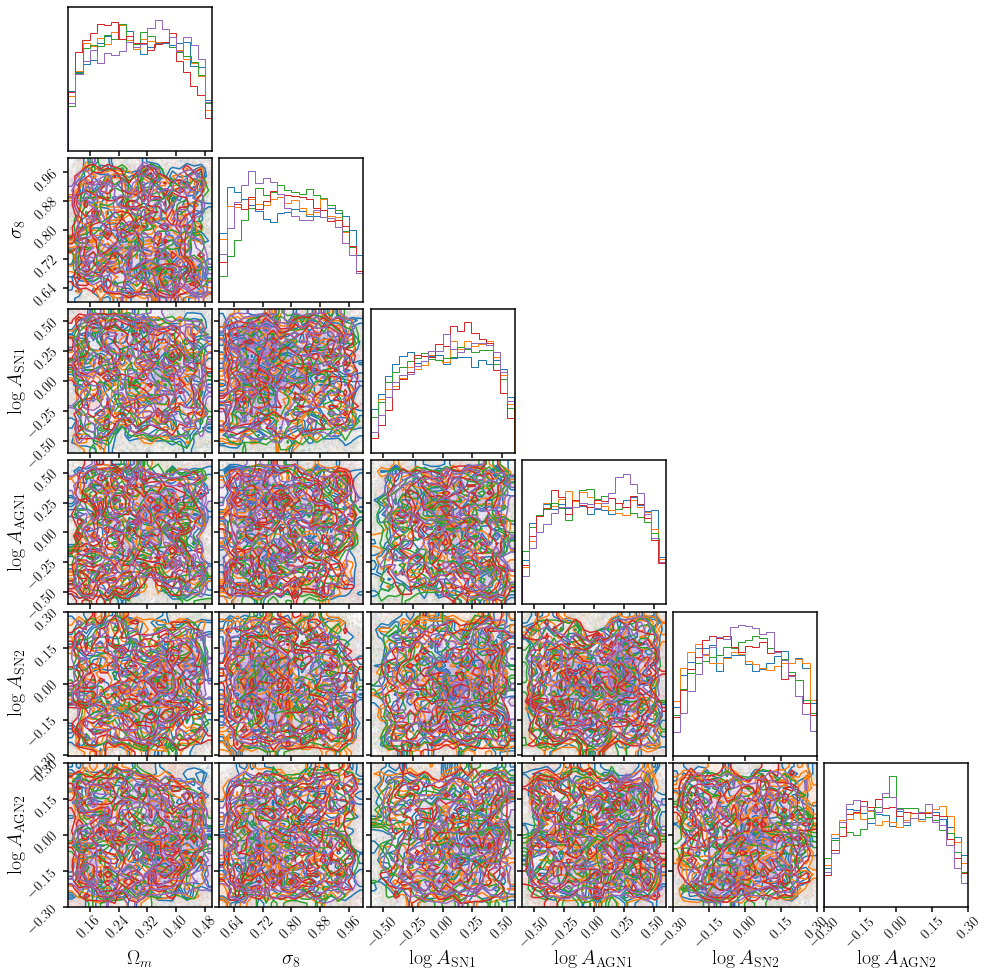

In [8]:
fig = None 
for i, qphi in enumerate(qphis): 
    _samp = qphi.sample((10000,),
                       x=torch.tensor(x_test[0], dtype=torch.float32).to(device), 
                       show_progress_bars=False)
    fig = DFM.corner(_samp.detach().cpu().numpy(), color='C%i' % i, 
                     labels=lbls, label_kwargs={'fontsize':20}, fig=fig)

In [7]:
n_sample = 10000

ranks, y_nde = [], []
for i in trange(500):#y_test.shape[0]): 
    y_samp = []
    for qphi in qphis: 
        _samp = qphi.sample((int(n_sample/len(qphis)),),
                           x=torch.tensor(x_test[i], dtype=torch.float32).to(device), 
                           show_progress_bars=False)

        y_samp.append(_samp.detach().cpu().numpy())
    y_nde.append(np.concatenate(np.array(y_samp), axis=0))        

    _ranks = []
    for i_dim in range(y_nde[-1].shape[1]): 
        _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < y_test[i, i_dim]))
    ranks.append(_ranks)

ranks = np.array(ranks)
y_nde = np.array(y_nde)

  0%|          | 0/500 [00:00<?, ?it/s]

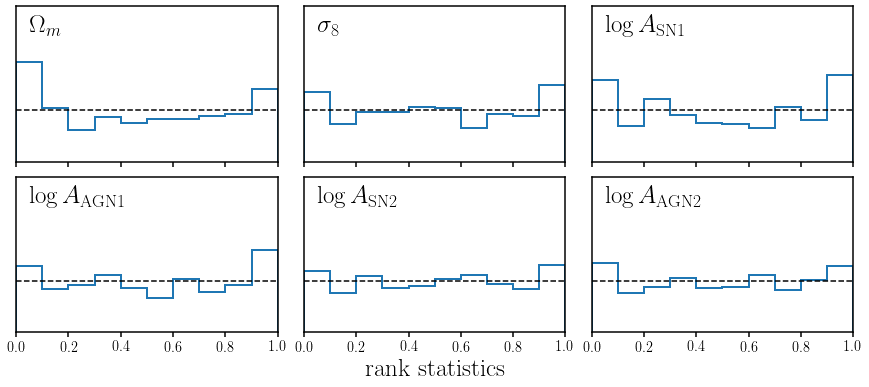

In [10]:
fig = plt.figure(figsize=(15, 6))
for i in range(y_test.shape[1]): 
    sub = fig.add_subplot(2,3,i+1)
    _ = sub.hist(ranks[:,i], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='C0') 
    sub.plot([0., 1.], [1., 1.], c='k', ls='--')
    
    sub.text(0.05, 0.95, lbls[i], fontsize=25, transform=sub.transAxes, ha='left', va='top')
    
    if i == 4: sub.set_xlabel('rank statistics', fontsize=25)
    if i < 3: sub.set_xticklabels([])
    sub.set_xlim(0., 1.)
    sub.set_ylim(0., 3.)
    sub.set_yticks([])
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig('../figs/ranks_p_omega_x.pdf', bbox_inches='tight')

## `tarp` validation

In [11]:
from tarp import get_drp_coverage

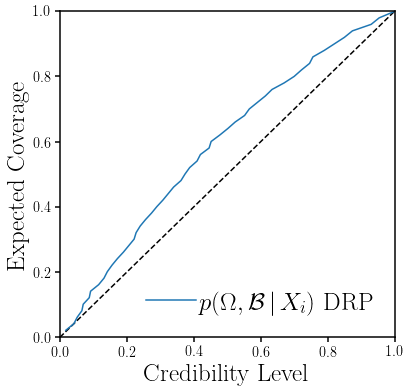

In [16]:
alpha, ecp = get_drp_coverage(np.swapaxes(y_nde, 0, 1), y_test[:500], references="random", metric="euclidean")

fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], ls="--", color="k")
ax.plot(alpha, ecp, label=r"$p(\Omega, \mathcal{B} \,|\, X_i)$ DRP")
ax.legend(loc='lower right', handletextpad=0.1, fontsize=25)
ax.set_ylabel("Expected Coverage", fontsize=25)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=25)
ax.set_xlim(0., 1.)
fig.savefig('../figs/tarp_p_omega_x.pdf', bbox_inches='tight')